# Training a (Toy) Language Model with Hugging Face

The following notebook was developed as part of the online course  
[**Train, Fine-Tune, and Deploy LLMs**](https://learn.theaiedge.io/p/the-large-language-bootcamp).

<p float="center">
  <img src="../../assets/llmpretraining.png" width="750" height="300"> 
</p>


### Goal: How to (Re-)Train a (Toy) Causal Language Model with Hugging Face
This notebook walks through a workflow of pre-training a small casual language model.
(It is designed of experimentation purposes on limited available hardware.)

#### Workflow
1. **Data Preparation**
    - load a small dataset (in this notebook, it is a subset of English Wikipedia dataset)
    - perform train/test split
    - tokenize text for casual langulage modeling
    - (if necessary) add padding token
2. **Pretrained Model Inspection**
    - load original pretrained causual lagnuage model (in this notebook `Mistral-7B`) from Hugging face Hub
    - generate sample text to use as baseline
3. **Custom small Model Configuration**
    - define a smaller Mistral-like architecture (e.g., fewer layers, smaller hidden size, reduced context window, etc.)
    - instantiate the model
4. **Training Setup**
    - Use `DataCollatorForLanguageModelling` for casual Language Modelling Training
    - Configure `Trainer` and `TrainerArguments`
    - Train the model on a (toy) small dataset
5. **Evaluate & Metrics**
    - compare generated text with original pretrained model (in this notebook `Mistral-7B`) outpus
    - compute perplexity on the evaluation set
    - compute perplexity on the same evaluation set for the original model
    - compare calculated perplexity metrics derived for toy model and the original one.
    - visualize training & evaluation loss as well as evaulation perplexity for every epoch
6. **Model Hub Integration**
    - (optional) push the trained model to the Hugging Face Hub

In [1]:
# enabling autoreloading of modules. This ensures any local edits/changes 
# to python modules are automatically reloaded without restarting the notebook
%load_ext autoreload
%autoreload 2

In [2]:
import os
from dotenv import load_dotenv

# load enviroment variables from .env file
load_dotenv()

# retrieve hugging face api token from environment (the token should be set in .env file 
# as HF_TOKEN=<huggingface_toke>)
hf_token = os.getenv('HF_TOKEN')
hf_username = os.getenv('HF_USERNAME')

# make sure that transformers, datasets and other libraries can access to HF token
os.environ['HF_TOKEN'] = hf_token

In [3]:
# Move model to device (prefer MPS on Apple Silicon, else CPU/GPU)
import torch
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

### 1. Data Prepartion

In [4]:
from datasets import load_dataset

# load small subset of wikipedia dataset (english language)
wikids = load_dataset(
    path="wikimedia/wikipedia",     # dataset namespace and name
    name="20231101.en",             # snapshot date (November 1st, 2023) + language code
    split="train[0:1000]",          # use only 1000 samples of data
    cache_dir=None,                 # set a custom cache dir for faster reloads
    keep_in_memory=False,           # keep in RAM (default False). Disabling the cache and copying the dataset in-memory will speed up dataset operations
)

Resolving data files:   0%|          | 0/41 [00:00<?, ?it/s]

In [5]:
wikids

Dataset({
    features: ['id', 'url', 'title', 'text'],
    num_rows: 1000
})

In [6]:
# quick sanity check:
# a) inspect first sample
display(wikids)

# b) preview first 100 characters of the first document
wikids['text'][0][:100]

Dataset({
    features: ['id', 'url', 'title', 'text'],
    num_rows: 1000
})

'Anarchism is a political philosophy and movement that is skeptical of all justifications for authori'

In [7]:
# split dataset into train and test sets
wikids = wikids.train_test_split(test_size=0.1)
wikids

DatasetDict({
    train: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 900
    })
    test: Dataset({
        features: ['id', 'url', 'title', 'text'],
        num_rows: 100
    })
})

In [8]:
from transformers import AutoTokenizer

# load pretrained tokenizer from hugging face hub
# https://huggingface.co/mistralai/Mistral-7B-v0.3
model_id = 'mistralai/Mistral-7B-v0.3'

tokenizer = AutoTokenizer.from_pretrained(
    pretrained_model_name_or_path=model_id
)

In [9]:
# inspect tokenizer config and default tokens
display(tokenizer.special_tokens_map)

print(tokenizer.pad_token, tokenizer.eos_token, tokenizer.bos_token, tokenizer.unk_token)

{'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>'}

None </s> <s> <unk>


In [10]:
# if tokenizer has no padding token defined (like Mistral 7B model), set on explicitly.
# hugging face convetion is to use '<|pad|>' for generative models
tokenizer.pad_token = '<|pad|>'

In [12]:
# sanity checks for padding token by considering large max_length
# in this case, attention mask will have 0 values for padded tokens
out0 = tokenizer(wikids['train']['text'][0], max_length=20_000, padding='max_length', padding_side='left')

print('last 10 and first 10 INPUT_IDS of the first training sample:')
display((out0['input_ids'][-10:], out0['input_ids'][:10]))

print('last 10 and first 10 ATTENTION_MASK of the first training sample:')
display((out0['attention_mask'][-10:], out0['attention_mask'][:10]))

print('padded token id is:', tokenizer.pad_token_id)

last 10 and first 10 INPUT_IDS of the first training sample:


([2929, 781, 2693, 1125, 1556, 1122, 5008, 1170, 7749, 5303],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

last 10 and first 10 ATTENTION_MASK of the first training sample:


([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

padded token id is: 0


In [12]:
wikids['train'][1]

{'id': '1799',
 'url': 'https://en.wikipedia.org/wiki/ATP',
 'title': 'ATP',
 'text': "ATP may refer to:\n\nScience, technology and biology \nAdenosine triphosphate, an organic chemical used for driving biological processes\nATPase, any enzyme that makes use of adenosine triphosphate\nAdvanced Technology Program, US government program\nAnti-tachycardia pacing, process similar to a pacemaker\nAlberta Taciuk process, for extracting oil from shale, etc.\nAutomated theorem proving, method of proving mathematical theorems by computer programs\n\nCompanies and organizations \n\n Association of Tennis Professionals, men's professional tennis governing body\nATP Tour\n American Technical Publishers, employee-owned publishing company\n Armenia Tree Project, non-profit organization\n Association for Transpersonal Psychology\n ATP architects engineers, architecture- and engineering office for integrated design\n ATP Oil and Gas, defunct US energy company\n\nEntertainment, arts and media \nAdenosi

In [13]:
from typing import Dict, List, Any

# define max token lengths for inputs
max_length = 512

def tokenize_function(sample: Dict[str, List[str]]) -> Dict[str, Any]:
    """
    tokenize a batch of text samples for casual language modeling

    Args:
        sample (Dict[str, List[str]]): a dictionary of dataset fields, where each field maps to a list of values.
        - Expected key: "text" (List[str]), a batch of raw text strings
        - Example: {
            ..., 
            'text': [
                'Abimelech (also spelled Abimelek ...',
                'Athene or Athena is the shrewd ...',
                ...
            ]
        }

    Returns:
        Dict[str, Any]: a dictionary with tokenized outputs, where each key corresponds to a model input filed:
        - 'input_ids' (List[List[int]): encoded token ids
        - 'attention_mask' (List[list[int]]): 1 for tokends to attend, and 0 for padding
        - 'token_type_ids' (Optional[List[list[int]]]): only for tokenizers that use them
    """    
    
    return tokenizer(
        sample['text'],             # batch of raw text strings
        padding='max_length',       # pad to a fixed length for batching
        truncation=True,            # truncate large texts if len(text) > max_length
        return_tensors='pt',        # return as pytorch tensors
        add_special_tokens=True,    # ensure begginging and end of sentence (<\bos>, and <\eos>) are added.
        max_length=max_length,      # hard cap on senquence length
    )


# apply tokenizer across dataset
tokenized = wikids.map(
    tokenize_function, 
    batched=True, 
    remove_columns=wikids['train'].column_names     # in case of wikids, columns are ['id', 'url', 'title', 'text']
)

Map:   0%|          | 0/900 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

In [14]:
# in comparision to wikids, features ['id', 'url', 'title', 'text'] were removed 
# and ['input_ids', 'attention_mask'] were added.
tokenized

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 900
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask'],
        num_rows: 100
    })
})

### 2. Pretrained Model Inspection

**Checkout the text generation of the PRETRAINED Mistral-7B model**

In [15]:
from transformers import MistralForCausalLM, MistralConfig

# get the original pretrained Mistral 7B model and check the model output
# we want to compare the results with a smaller trained model!
model_org = MistralForCausalLM.from_pretrained(model_id, device_map='mps')

# generate output using the PRETRAINED MISTRAL MODEL 
inputs = tokenizer("Once upon a time", return_tensors="pt").to(model_org.device)
outputs = model_org.generate(**inputs, max_length=100)
tokenizer.decode(outputs[0], skip_special_tokens=False)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'<s> Once upon a time, there was a little girl who loved to read. She loved to read so much that she would read books over and over again. She would read books about princesses and fairies and dragons and wizards. She would read books about pirates and mermaids and unicorns and witches. She would read books about knights and castles and kings and queens. She would read books about magic and adventure and mystery and romance. She'

### 3. Custom small Model Configuration
**Define a smaller Mistral-like config for experimentation**

In [16]:
MistralConfig()

MistralConfig {
  "attention_dropout": 0.0,
  "bos_token_id": 1,
  "eos_token_id": 2,
  "head_dim": 128,
  "hidden_act": "silu",
  "hidden_size": 4096,
  "initializer_range": 0.02,
  "intermediate_size": 14336,
  "max_position_embeddings": 131072,
  "model_type": "mistral",
  "num_attention_heads": 32,
  "num_hidden_layers": 32,
  "num_key_value_heads": 8,
  "rms_norm_eps": 1e-06,
  "rope_theta": 10000.0,
  "sliding_window": 4096,
  "tie_word_embeddings": false,
  "transformers_version": "4.48.1",
  "use_cache": true,
  "vocab_size": 32000
}

In [17]:
# consider smaller model that fits on my laptop
config = MistralConfig(
    hidden_size=1024,                       # reduced hidden size (default 4096 in Mistral-7B model)
    sliding_window=1024,                    # reduced sliding window (default 4096 in Mistral-7B model)
    intermediate_size=3077*2,               # FeedForward Network size (default 14336 in Mistral-7B model)
    max_position_embeddings=max_length,     # reduced max_position_embeddings (default 131072 in Mistral 7B-Model)
    num_attention_heads=16,                 # reduced num_attention_heads (default 32 in Mistral-7B model)
    num_hidden_layers=8                     # Number of decoder blocks (default 32 in Mistral-7B model)
)


# instantiate small Mistral model from customized config file
model = MistralForCausalLM(config)
model = model.to(device)

In [18]:
# check if model parameters are on 'mps'
print(next(model.parameters()).device)

mps:0


In [19]:
# inspect model size
model_param_size = sum([param.numel() for param in model.parameters()])
print(f'Model parameter count: {model_param_size:,}')

Model parameter count: 241,959,936


### 4. Training Setup

In [ ]:
# in causual language model, the labels are the same as input
from transformers import DataCollatorForLanguageModeling

# data collator prepares batches of tokenized text for training
# in causal ML training, labels are identical to inputs 
# (however, HuggingFace automatically shifts the labels during trainig)
data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer,
    mlm=False, # no masked language modelling -> causual LM
    return_tensors='pt'
)

In [ ]:
# test batch collation

# note that tokenized['train'][i] is a dictionary with keys: input_ids, attention_mask, etc.
# and tokenized['train'][0:1] returns a Dataset object (a slice of length 1), not a list of dicts.
data_collator(
    [tokenized['train'][i] for i in range(2)]   # a list of dictionaries
)   # creates a batch of 2 samples

{'input_ids': tensor([[    1,  1098, 24285,  ...,  2142, 14833,  1093],
        [    0,     0,     0,  ...,  3856,  1059,  3435]]), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1]]), 'labels': tensor([[    1,  1098, 24285,  ...,  2142, 14833,  1093],
        [ -100,  -100,  -100,  ...,  3856,  1059,  3435]])}

In [22]:
from transformers import Trainer, TrainingArguments

# define training argument (adjust based on available resources)
trainings_args = TrainingArguments(
    output_dir="mistral7B/pretrained",  # where to save the model
    overwrite_output_dir=True,          # overwrite the content of the output directory
    num_train_epochs=10,                # number of training epochs
    per_device_train_batch_size=4,      # batch size for training
    per_device_eval_batch_size=4,       # batch size for evaluation
    eval_strategy="epoch",              # log eval metrics at each epoch
    logging_strategy="epoch",           # log training loss at each epoch
    save_strategy="no",                 # disables checkpoint saving altogether (for model experimentation)
    report_to='none',                   # disable wandb as we are not using it here
    bf16=False,                         # use bf16 if your GPU supports it
    push_to_hub=True,                   # whether to push the model to the Hub or not (default False)
    hub_model_id=f'{hf_username}/dummy-pretrained-mistral7b',  # set the repo name
    hub_private_repo=False              # set True for private repo
)

# Trainer handles training loop, evaluation, and logging
trainer = Trainer(
    model=model,
    args=trainings_args,
    train_dataset=tokenized['train'],
    eval_dataset=tokenized['test'],
    data_collator=data_collator,
    processing_class=tokenizer
)

# train (small) model on a small dataset (for experimentation purpose)
trainer.train()

Epoch,Training Loss,Validation Loss
1,7.142700,6.458823
2,6.087000,6.056936
3,5.497400,5.884968
4,4.911800,5.838583
5,4.329300,5.884121
6,3.803100,5.979115
7,3.358000,6.069305
8,2.994200,6.164049
9,2.710100,6.212510
10,2.518900,6.260774


TrainOutput(global_step=2250, training_loss=4.335245985243056, metrics={'train_runtime': 1298.0726, 'train_samples_per_second': 6.933, 'train_steps_per_second': 1.733, 'total_flos': 5783738646528000.0, 'train_loss': 4.335245985243056, 'epoch': 10.0})

### 5. Evaluate & Metrics

In [23]:
# quick text generation (and compared with the output of the pretrained Mistral-7B model)
inputs = tokenizer("Once upon a time", return_tensors="pt").to(model.device)
outputs = model.generate(**inputs, max_length=100)
tokenizer.decode(outputs[0], skip_special_tokens=True)

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


'Once upon a time of the in which a name of the ancient Greek Greek Greek 35th century to his father as the Greek. He was the Greek Greek. \n\nLife\n\nAncia was a son of King\n\nAncia, a son of King\n\nSee also\n\nSee also\n\nSee also\n\nSee also\n\nSee also\n\nSee also\n\nSee also\n\nSee also\n\nBon (disambiguation\n'

#### Perplexity Metric
To measure the quality of lm training, a common metric is perplexity which is defined as follows:
> $\text{Perplexity} = 2^{\left\{ -\frac{1}{T} \sum_{i=1}^{T} \log_2 p(t_i) \right\}} = e^{\left\{ -\frac{1}{T} \sum_{i=1}^{T} \ln p(t_i) \right\}}$

where $T$ is total number of tokens in test set and $p(t_i)$ is probability of ith token in test set (Note that $\log_2(x) = \frac{\ln x}{\ln 2}$ is used to rewrite perplexity from base-2 log to base-$e$ one). 

#### Interpretation
- If the model is perfectly confident in predicting the next token, then **Perplexity = 1**.  
- Higher values indicate more uncertainty. For example:  
  - A perplexity of **500** means that, on average, predicting the next token is as uncertain as choosing uniformly among **500 equally likely options**.  
  - The original **pretrained Mistral-7B** model achieves a perplexity of around **5** on the same dataset, showing that our toy model severely underperforms in comparison.

In [24]:
# evaluate perplexity metric for the small (toy) model
import math

eval_results = trainer.evaluate()
if eval_results.get('eval_loss'):
    print("Perplexity:", math.exp(eval_results["eval_loss"]))

Perplexity: 523.6241393300244


In [26]:
# lets compare the perplexity metric of the toy model with the original Mistral-7B one.

# define temporary training arguments (needed just for evaluation and not training)
eval_args = TrainingArguments(
    output_dir = 'eval_temp',
    per_device_eval_batch_size=16,   # adjust based on available memory
    report_to='none'
)

# use the same data collator
trainer_org = Trainer(
    model=model_org,
    args=eval_args,
    eval_dataset=tokenized['test'],
    data_collator=data_collator,
    processing_class=tokenizer
)

# Evaluate loss on test set
eval_results_org = trainer_org.evaluate()
if eval_results_org.get("eval_loss"):
    ppl = math.exp(eval_results_org["eval_loss"])
    print("Perplexity of pretrained Mistral-7B:", ppl)

Perplexity of pretrained Mistral-7B: 4.798891173887928


Visualization of loss and perplexity for every training epoch

In [27]:
import pandas as pd 

# get training logs and convert it to dataframe
logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)
df_logs = df_logs[["epoch", "loss", "eval_loss"]].dropna(how="all")

# compute perplexity from eval_loss for every epoch
df_logs['perplexity'] = df_logs['eval_loss'].apply(lambda x: math.exp(x) if pd.notnull(x) else None)
df_logs

,epoch,loss,eval_loss,perplexity
0,1.0,7.1427,NaN,NaN
1,1.0,NaN,6.458823,638.309150
2,2.0,6.0870,NaN,NaN
3,2.0,NaN,6.056936,427.065016
4,3.0,5.4974,NaN,NaN
5,3.0,NaN,5.884968,359.591190
6,4.0,4.9118,NaN,NaN
7,4.0,NaN,5.838583,343.292711
8,5.0,4.3293,NaN,NaN
9,5.0,NaN,5.884121,359.286795


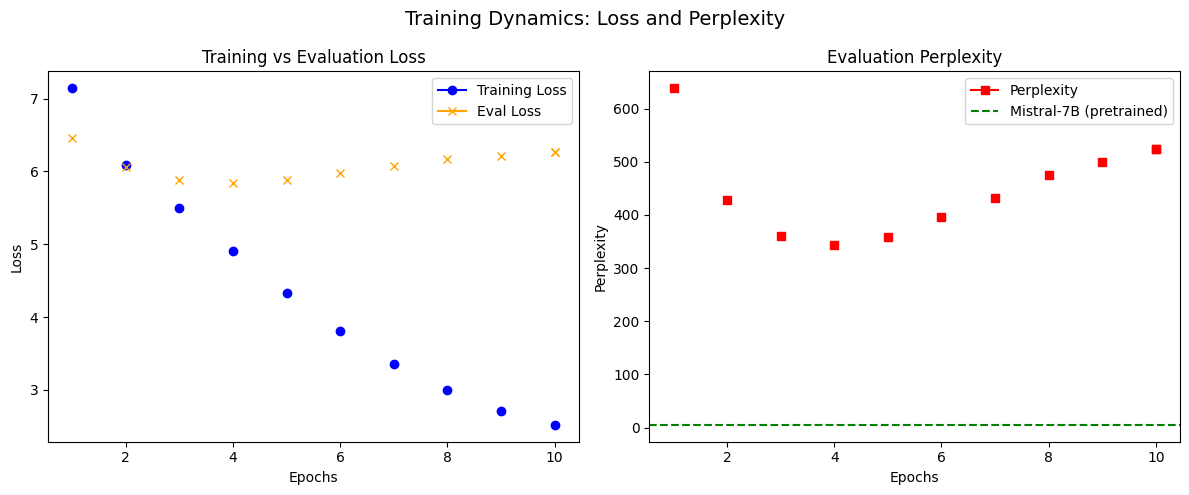

In [ ]:
import matplotlib.pyplot as plt

# --- Plotting ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))

# Plot training & evaluation loss
ax1.plot(df_logs["epoch"], df_logs["loss"], label="Training Loss", color="blue", marker="o")
ax1.plot(df_logs["epoch"], df_logs["eval_loss"], label="Eval Loss", color="orange", marker="x")
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax1.set_title("Training vs Evaluation Loss")
ax1.legend()

# Plot perplexity (calcuated on the evaluation set)
ax2.plot(df_logs["epoch"], df_logs["perplexity"], label="Perplexity", color="red", marker="s")
ax2.axhline(y=5, color="green", linestyle="--", label="Mistral-7B (pretrained)")
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Perplexity")
ax2.set_title("Evaluation Perplexity")
ax2.legend()

plt.tight_layout()
plt.show()

### 6. Model Hub Integration

In [29]:
# push the model to huggingface hub (we want to use it later for fine tuning)
trainer.push_to_hub();

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

training_args.bin:   0%|          | 0.00/5.30k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/968M [00:00<?, ?B/s]

In [ ]:
# if removing the model from hugging face is desired
from huggingface_hub import delete_repo

# delete a model repo
delete_repo(
    repo_id=f"{hf_username}/my_repo_id",
    repo_type="model"                # defaults to dataset
)